In [85]:
import requests
import json
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

## Load predictions from DB

In [27]:

def get_predictions_datahora_teste(conn):
    query = f'''
           select
           *
           from vehicle_tracking_pred_datahora_teste
            '''
        
    # Carregar dados em um GeoDataFrame
    df = pd.read_sql(query, conn)

    return df



def get_predictions_latlong_teste(conn):
    query = f'''
           select
           *
           from vehicle_tracking_pred_latlong_teste
            '''
        
    # Carregar dados em um GeoDataFrame
    df = pd.read_sql(query, conn)

    return df



In [28]:
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)



df_pred_datahora = get_predictions_datahora_teste(conn)
df_pred_latlong = get_predictions_latlong_teste(conn)
conn.close()


C:\Users\lucas\AppData\Local\Temp\ipykernel_47596\1872398597.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\lucas\AppData\Local\Temp\ipykernel_47596\1872398597.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Generate  Requests for time prediction
- password: 120040005
- aluno: Maria Luiza

In [79]:
# Adicionar a coluna 'datahora' com base no nome do arquivo
df_pred_datahora['datahora'] = df_pred_datahora['filename'].str.extract(r'teste-(\d{4}-\d{2}-\d{2}_\d{2})\.json')[0]
df_pred_datahora[['id', 'datahora_epoch_pred']] = df_pred_datahora[['id', 'datahora_epoch_pred']].astype('Int64')

# Agrupar as previsões por filename
grouped = df_pred_datahora.groupby('filename').apply(lambda x: x[['id', 'datahora_epoch_pred']].values.tolist()).reset_index(name='previsoes')

# Construir a estrutura final em formato de lista de dicionários
json_datas = []
for _, row in grouped.iterrows():
    json_datas.append({
        "aluno": "Maria Luiza",
        "datahora": f'{pd.to_datetime(row['filename'].replace('.json', ''), format='teste-%Y-%m-%d_%H').strftime('%Y-%m-%d %H:%M:%S')}',
        "previsoes": row['previsoes'],
        "senha": "120040005"
    })


C:\Users\lucas\AppData\Local\Temp\ipykernel_47596\670506196.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_pred_datahora.groupby('filename').apply(lambda x: x[['id', 'datahora_epoch_pred']].values.tolist()).reset_index(name='previsoes')


In [80]:
# URL of the endpoint
url = 'https://barra.cos.ufrj.br:443/rest/rpc/avalia'

# Headers for the request
headers = {
    'accept': 'application/json',
    'Content-Type': 'application/json'
}



In [81]:
results = []

# Iterar sobre cada JSON em json_data
for json_obj in json_datas:
    print('Uploading', json_obj["datahora"])
    json_data = json.dumps(json_obj)
    response = requests.post(url, headers=headers, data=json_data)
    # Verificar se a solicitação foi bem sucedida
    if response.status_code == 200:
      # Obter os dados da resposta
        response_data = response.json()
        
        # Construir o dicionário com todos os dados da resposta
        result_dict = {
            'datahora': json_obj['datahora'],
            'rmse': response_data.get('rmse', None),
            'ids_nao_encontrados': response_data.get('ids não encontrados', None),
            'ids_testados': response_data.get('ids testados', None),
            'total_na_tabela': response_data.get('total na tabela', None)
        }
        
        # Adicionar o resultado à lista de resultados
        results.append(result_dict)
        print(f"Response RMSE for {json_obj['datahora']}: {response_data.get('rmse', 'N/A')}")
    else:
        print(f'Failed to get RMSE for {json_obj["datahora"]}. Status code: {response.status_code}')


Uploading 2024-05-16 12:00:00
Response RMSE for 2024-05-16 12:00:00: 50160.504036144375
Uploading 2024-05-16 20:00:00
Response RMSE for 2024-05-16 20:00:00: 39381.67812230565
Uploading 2024-05-17 11:00:00
Response RMSE for 2024-05-17 11:00:00: 48456.05674965634
Uploading 2024-05-17 19:00:00
Response RMSE for 2024-05-17 19:00:00: 44541.72401256825
Uploading 2024-05-18 08:00:00
Response RMSE for 2024-05-18 08:00:00: 40220.22606325987
Uploading 2024-05-18 16:00:00
Response RMSE for 2024-05-18 16:00:00: 49448.92793810916
Uploading 2024-05-19 15:00:00
Response RMSE for 2024-05-19 15:00:00: 38102.45611784274
Uploading 2024-05-20 13:00:00
Response RMSE for 2024-05-20 13:00:00: 62132.07002161552
Uploading 2024-05-20 21:00:00
Response RMSE for 2024-05-20 21:00:00: 50510.13252258


In [83]:
df_results= pd.DataFrame(results)

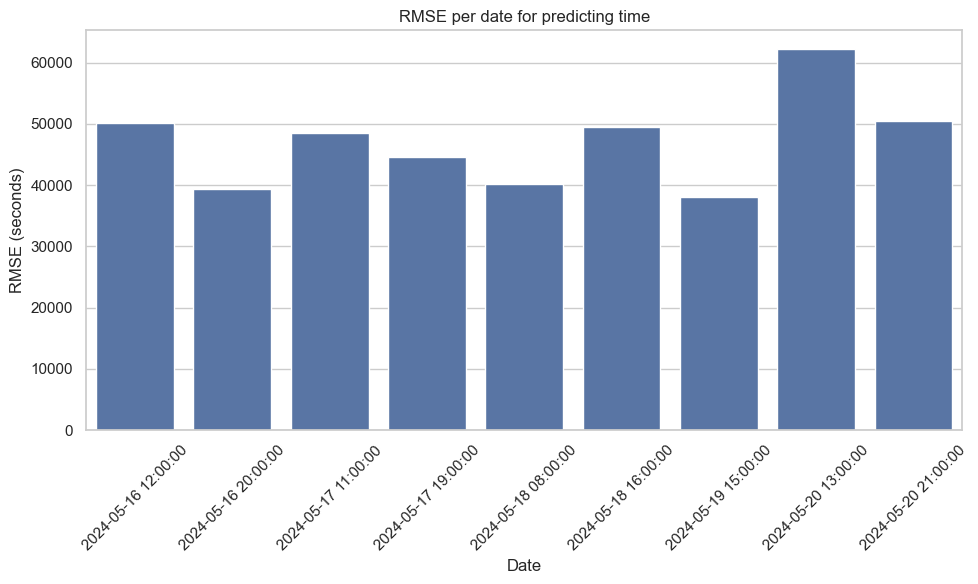

In [91]:
# Configurações padrão do seaborn
sns.set(style="whitegrid")

# Plotar o gráfico de RMSE por Data/Hora com seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='datahora', y='rmse', data=df_results)
plt.title('RMSE per date for predicting time')
plt.xlabel('Date')
plt.ylabel('RMSE (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()

# Exibir o gráfico
plt.show()

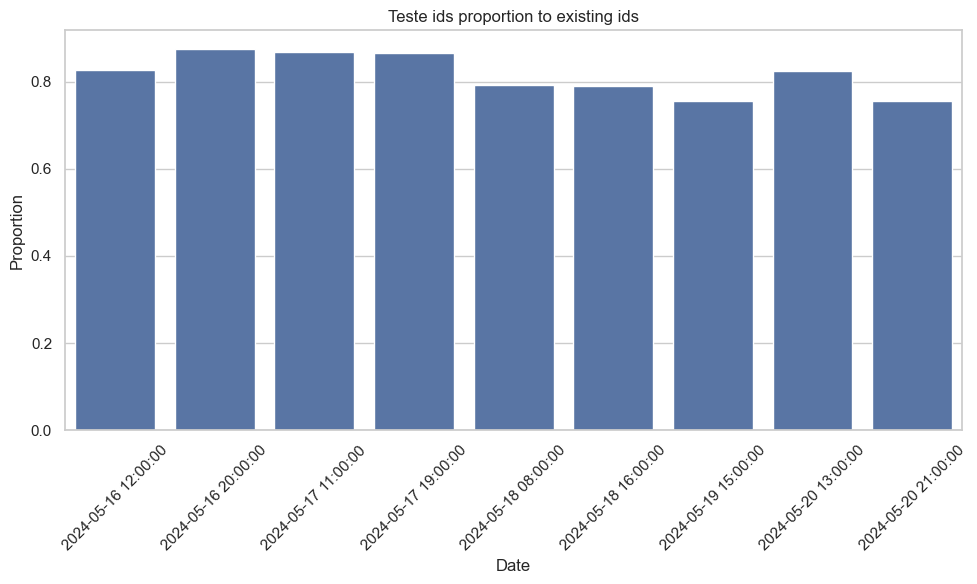

In [92]:
# Calcular a proporção de IDs testados em relação ao total na tabela
df_results['proporcao_ids_testados'] = df_results['ids_testados'] / df_results['total_na_tabela']

# Plotar o gráfico da Proporção de IDs Testados com seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='datahora', y='proporcao_ids_testados', data=df_results)
plt.title('Teste ids proportion to existing ids')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()


- Proportion is almost above 80% for every file, seems like a good rate for testing

## Generate  Requests for Lat Long
- password: 120040005
- aluno: Maria Luiza

In [96]:
# Adicionar a coluna 'datahora' com base no nome do arquivo
df_pred_latlong['datahora'] = df_pred_latlong['filename'].str.extract(r'teste-(\d{4}-\d{2}-\d{2}_\d{2})\.json')[0]
df_pred_latlong[['latitude_pred', 'longitude_pred']] = df_pred_latlong[['latitude_pred', 'longitude_pred']].astype('float')
df_pred_latlong['id'] = df_pred_latlong['id'].astype('Int64')
# Agrupar as previsões por filename
grouped = df_pred_latlong.groupby('filename').apply(lambda x: x[['id', 'latitude_pred', 'longitude_pred']].values.tolist()).reset_index(name='previsoes')

# Construir a estrutura final em formato de lista de dicionários
json_datas = []
for _, row in grouped.iterrows():
    json_datas.append({
        "aluno": "Maria Luiza",
        "datahora": f'{pd.to_datetime(row['filename'].replace('.json', ''), format='teste-%Y-%m-%d_%H').strftime('%Y-%m-%d %H:%M:%S')}',
        "previsoes": row['previsoes'],
        "senha": "120040005"
    })


C:\Users\lucas\AppData\Local\Temp\ipykernel_47596\263849757.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_pred_latlong.groupby('filename').apply(lambda x: x[['id', 'latitude_pred', 'longitude_pred']].values.tolist()).reset_index(name='previsoes')


In [98]:
results = []

# Iterar sobre cada JSON em json_data
for json_obj in json_datas:
    print('Uploading', json_obj["datahora"])
    json_data = json.dumps(json_obj)
    response = requests.post(url, headers=headers, data=json_data)
    # Verificar se a solicitação foi bem sucedida
    if response.status_code == 200:
      # Obter os dados da resposta
        response_data = response.json()
        
        # Construir o dicionário com todos os dados da resposta
        result_dict = {
            'datahora': json_obj['datahora'],
            'rmse': response_data.get('rmse', None),
            'ids_nao_encontrados': response_data.get('ids não encontrados', None),
            'ids_testados': response_data.get('ids testados', None),
            'total_na_tabela': response_data.get('total na tabela', None)
        }
        
        # Adicionar o resultado à lista de resultados
        results.append(result_dict)
        print(f"Response RMSE for {json_obj['datahora']}: {response_data.get('rmse', 'N/A')}")
    else:
        print(f'Failed to get RMSE for {json_obj["datahora"]}. Status code: {response.status_code}')


Uploading 2024-05-16 08:00:00
Response RMSE for 2024-05-16 08:00:00: 11216.397800571995
Uploading 2024-05-16 16:00:00
Response RMSE for 2024-05-16 16:00:00: 11173.286466874499
Uploading 2024-05-17 15:00:00
Response RMSE for 2024-05-17 15:00:00: 11121.37503826456
Uploading 2024-05-18 12:00:00
Response RMSE for 2024-05-18 12:00:00: 11509.168803821443
Uploading 2024-05-18 20:00:00
Response RMSE for 2024-05-18 20:00:00: 11635.992823256574
Uploading 2024-05-19 11:00:00
Response RMSE for 2024-05-19 11:00:00: 11585.042929315177
Uploading 2024-05-19 19:00:00
Response RMSE for 2024-05-19 19:00:00: 11678.061746000094
Uploading 2024-05-20 09:00:00
Response RMSE for 2024-05-20 09:00:00: 11366.67643884021
Uploading 2024-05-20 17:00:00
Response RMSE for 2024-05-20 17:00:00: 10766.367045546074


In [ ]:
df_results= pd.DataFrame(results)

In [ ]:
# Configurações padrão do seaborn
sns.set(style="whitegrid")

# Plotar o gráfico de RMSE por Data/Hora com seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='datahora', y='rmse', data=df_results)
plt.title('RMSE per date for predicting lat long')
plt.xlabel('Date')
plt.ylabel('RMSE (meters)')
plt.xticks(rotation=45)
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [ ]:
# Calcular a proporção de IDs testados em relação ao total na tabela
df_results['proporcao_ids_testados'] = df_results['ids_testados'] / df_results['total_na_tabela']

# Plotar o gráfico da Proporção de IDs Testados com seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='datahora', y='proporcao_ids_testados', data=df_results)
plt.title('Teste ids proportion to existing ids for predicting lat long')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
